In [21]:
#Entirely untested. Like that'll work!
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import pandas as pd
import math
import time
import statistics
from tqdm import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
tf.config.run_functions_eagerly(True)
size=2000
parquet = True

In [22]:
n = 1  # Number of channels
dt = tf.constant(0.1, dtype=tf.float32)
T = tf.constant(size, dtype=tf.int32)  # In sample points :-)
#Must be a multiple of 2!!!

In [23]:
@tf.function(experimental_compile=True)
def tf_relaxation(binary_sequence, half_life=4.0, relaxation_amount=0.2):
    """
    Apply exponential relaxation to a 1D binary sequence using vectorized TensorFlow operations.
    Kind of works backward to what you might think.  Where amp i1 1 and relaxation 0f 0.5 is too 0.5 therefore
    relaxation -0.5 is 0 to 1 but it then slowly rising to 1.5
    Args:
    binary_sequence: tf.Tensor, shape [time_steps], sequence of 0s and 1s
    half_life: float, the half-life of the exponential decay
    relaxation_amount: float, the amount of relaxation (positive or negative)
    Kind of works backward to what you might think.  Where amp i1 1 and relaxation 0f 0.5 is too 0.5 therefore
    relaxation -0.5 is 0 to 1 but it then slowly rising to 1.5
    Returns:
    tf.Tensor, shape [time_steps]
    """
    # Convert input to float32
    binary_sequence = tf.cast(binary_sequence, tf.float32)
    
    # Calculate decay rate
    decay_rate = tf.math.log(2.0) / half_life
    
    # Find the indices where steps occur
    steps = tf.not_equal(binary_sequence[1:] - binary_sequence[:-1], 0)
    step_indices = tf.where(steps)[:, 0]
    
    # Calculate the time since each step
    time_steps = tf.range(tf.shape(binary_sequence)[0], dtype=tf.float32)
    time_since_step = time_steps[:, tf.newaxis] - tf.cast(step_indices, tf.float32)
    
    # Calculate the exponential decay for each step
    decay = tf.exp(-decay_rate * tf.maximum(time_since_step, 0.0))
    
    # Calculate the relaxation effect
    step_values = tf.gather(binary_sequence, step_indices + 1) - tf.gather(binary_sequence, step_indices)
    relaxation_effect = relaxation_amount * step_values * decay
    
    # Sum the effects of all steps
    total_relaxation = tf.reduce_sum(relaxation_effect, axis=1)
    
    # Add the relaxation to the original sequence
    relaxed_sequence = binary_sequence + total_relaxation
    
    return relaxed_sequence

In [24]:
@tf.function(experimental_compile=True)
def normalize_row(row):
    # Find non-zero elements
    non_zero_mask = tf.not_equal(row, 0.0)
    non_zero_sum = tf.reduce_sum(tf.boolean_mask(row, non_zero_mask))
    
    # Normalize only non-zero elements
    normalized_row = tf.where(
        non_zero_mask,
        row / non_zero_sum,
        row
    )      
    return normalized_row

In [25]:
#This is only going to work properly with n = 1 and it's slow.
@tf.function(experimental_compile=True)
def sim_channel(params, num_steps=T, n=1):
    pc12, pc21, relaxation, Fnoise, scale, offset, relaxT, pco1, poc2, po12, po21 = params
    zero = tf.constant(0.0, dtype=tf.float32)
    
    unnormalized_matrix = tf.stack([
         #s0     #s1  #s2   #s3
        [1-pc12, pc12, zero,   zero],          # state 0 CLOSED
        [pc21, 1-pc21-pco1, pco1, zero],   # state 1 CLOSED
        [zero, poc2, 1-poc2-po12, po12],   # state 2 OPEN
        [zero,    zero,   po21, 1-po21]        # state 3 OPEN
    ])
    
    # Normalize each row while preserving zero probabilities
    transition_matrix = tf.map_fn(normalize_row, unnormalized_matrix)

    initial_distribution = tfp.distributions.Categorical(probs=[0.3, 0.3, 0.2, 0.2])
    
    markov_chain = tfp.distributions.MarkovChain(
        initial_state_prior=initial_distribution,
        transition_fn=lambda _, state: tfp.distributions.Categorical(probs=tf.gather(transition_matrix, state)),
        num_steps=num_steps
    )
    states = markov_chain.sample()
    #Assuming we have one channel so emission is...
    emissions = tf.where(tf.less(states, 2), tf.zeros_like(states), tf.ones_like(states))

    channels = tf.cast(emissions, dtype=tf.float32)
    # Generate pink noise
    white_noise = tf.random.normal(shape=[T])
    fft_len = T // 2 + 1
    f = tf.range(1, fft_len, dtype=tf.float32)
    spectrum = 1.0 / tf.sqrt(f)
    spectrum = tf.concat([tf.constant([1.0]), spectrum], axis=0)
    white_noise_fft = tf.signal.rfft(white_noise)
    pink_noise_fft = white_noise_fft * tf.cast(spectrum, tf.complex64)
    pink_noise = tf.signal.irfft(pink_noise_fft)
    pink_noise -= tf.reduce_mean(pink_noise)
    pink_noise = pink_noise / tf.math.reduce_std(pink_noise)
    noise = pink_noise * Fnoise

    # Add relaxation
    modified_raw_column = (channels * scale) + offset
    modified_raw_column = tf_relaxation(modified_raw_column, half_life=relaxT, relaxation_amount=relaxation)
    
    modified_raw_column += noise

    # Combine channels and modified raw column
    image = tf.stack([channels, modified_raw_column], axis=1)
    
    # Final safeguard against NaN values
    image = tf.where(tf.math.is_nan(image), tf.zeros_like(image), image)
    
    return image


In [28]:
# Parameters for the exponential distribution
num_samples = 5
saveSim=True
"""pc12, pc21, relaxation, Fnoise, scale, offset, relaxT, pco1, poc2, po12, po21"""
pc12 = tf.constant(.01, dtype=tf.float32)  # Decreased from 0.1
pc21 = tf.constant(.8, dtype=tf.float32)  # Decreased from 0.1
pco1 = tf.constant(0.1, dtype=tf.float32)  # Decreased from 0.01
poc2 = tf.constant(1e-1, dtype=tf.float32)  # Decreased from 0.0001
po12 = tf.constant(0.8, dtype=tf.float32)  # Decreased from 0.01
po21 = tf.constant(1e-1, dtype=tf.float32)


relaxation = tf.constant(0.5, dtype=tf.float32)
Fnoise = tf.constant(.04, dtype=tf.float32)
SCALE = tf.constant(.6, dtype=tf.float32)
#And an offset
OFFSET = tf.constant(-0.4, dtype=tf.float32)
relaxT=25
# nE = tf.constant(200, dtype=tf.int32) #number of events


# Generate training data
training_data = []
lens=[]
saver=[]
"""Actually replace "Anoise" with relaxation later"""
for sample in tqdm(range(num_samples)):   
    params = tf.stack([pc12, pc21, relaxation, Fnoise, SCALE, OFFSET, relaxT, pco1, poc2, po12, po21])  # Use tf.stack instead of tf.constant
    segment = sim_channel(params, n=n)
    lens.append(sum(abs(segment)))
    training_data.append(segment)
    if saveSim:
        saver.extend(segment)
print(f"Average duration was {sum(lens)/len(lens)}")
if saveSim:
    time_col = np.arange(0, len(saver) * dt, dt)
    np_data = np.column_stack((time_col, np.asarray(saver) ))
    #May have to untensorflow this output
    # Convert to a pandas DataFrame
    df = pd.DataFrame(np_data, columns=['Time', 
                                              'Channels', 
                                              'Noisy Current'])
    if parquet:
        df.to_parquet("regularSimv10Moon.parquet", index=False)
    else:
        df.to_csv("regularSimv10Moon.csv", index=False)

100%|█████████████████████████████████████████████████████████████| 5/5 [01:24<00:00, 16.84s/it]


Average duration was [178.     765.6853]


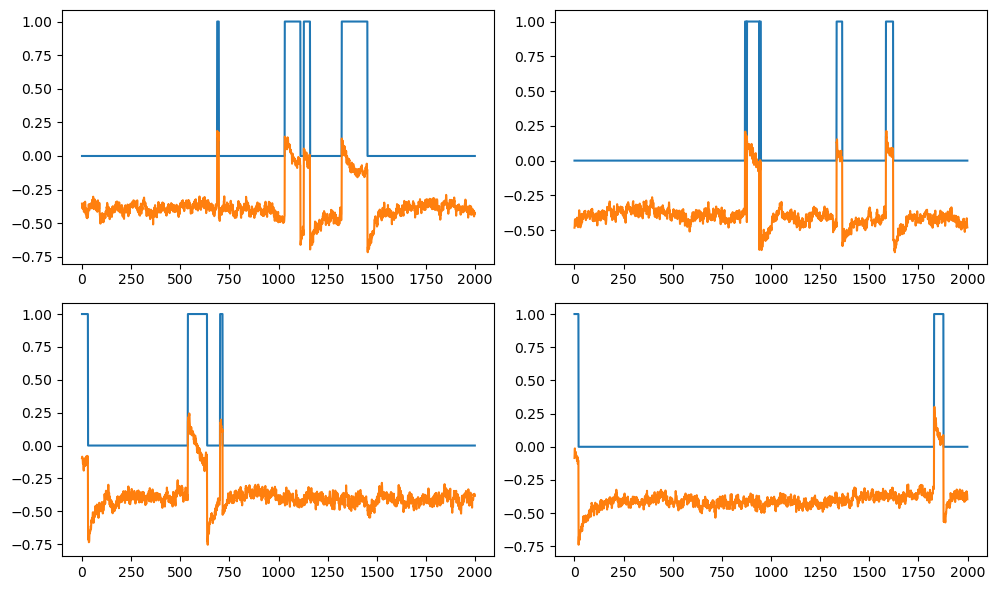

In [29]:
def plotter(data):
    # Create a figure with two subplots (panels)
    fig, axs = plt.subplots(2, 2, figsize=(10, 6))
     # Flatten the axs array for easy iteration
    axs = axs.flatten()
    
    for i in range(4):
        axs[i].plot(data[i])
        #axs[i].set_ylim([-200, 200])
    plt.tight_layout()
    plt.show()

plotter(training_data)